For each account I will train multiple ARIMA models on the train set. Then I will compute the MAPE for each window and keep the model taht performs best. I will then use it over the test set to get a final score to compare to other models.

Concerning the use of ARIMA models, there is no need to split data into train/validate/test, but only train/test.

In [79]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
import pandas as pd

pd.set_option("display.max_rows", 500)

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()

import warnings

warnings.filterwarnings("ignore")

from typing import Tuple

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error

import itertools

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
df_final = pd.read_csv("../data/transactions_final_set.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Split train / test

In [115]:
def split_train_validation_test(
    df: pd.DataFrame, ratio_train: float, ratio_validation: float
) -> Tuple[pd.DataFrame]:
    """
    Return a tuple of 3 DataFrames containing train, validation and test sets.
    The split must respect the chronological order.
    """
    dfs_train = []
    dfs_validation = []
    dfs_test = []

    for account_id in df["account_id"].unique():
        df_temp = (
            df[df["account_id"] == account_id]
            .sort_values(by="date")
            .reset_index(drop=True)
        )
        index_train, index_validation = int(len(df_temp) * ratio_train), int(
            len(df_temp) * (ratio_validation + ratio_train)
        )
        dfs_train.append(df_temp[:index_train])
        dfs_validation.append(df_temp[index_train:index_validation])
        dfs_test.append(df_temp[index_validation:])

    return (
        pd.concat(dfs_train, ignore_index=True),
        pd.concat(dfs_validation, ignore_index=True),
        pd.concat(dfs_test, ignore_index=True),
    )


df_train, df_test, _ = split_train_validation_test(
    df=df_final, ratio_train=0.8, ratio_validation=0.2
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
def mean_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (
        np.mean(
            np.abs((y_true - y_pred) / y_true)[
                np.isfinite(np.abs((y_true - y_pred) / y_true))
            ]
        )
        * 100
    )


def evaluate_arima_model(df: pd.DataFrame, arima_order: Tuple[int]) -> float:
    predictions = []
    for _, row in df.iterrows():
        train_row = [row[f"previous_amount_{i}"] for i in range(12, 0, -1)]
        model = ARIMA(train_row, order=arima_order)
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
    mape_error = mean_absolute_percentage_error(
        df["amount"].values, np.array(predictions)
    )
    mae_error = mean_absolute_error(df["amount"].values, np.array(predictions))

    return mape_error, mae_error

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [128]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [129]:
models_mape_errors = {}
models_mae_errors = {}


def add_prediction_to_dict(predictions_dict: dict, key: str, val: float) -> None:
    try:
        predictions_dict[key].append(val)
    except KeyError:
        predictions_dict[key] = [val]
    return None


for order in pdq:
    for account_id in df_train["account_id"].unique():
        df_temp = df_train[df_train["account_id"] == account_id]
        try:
            mape_error, mae_error = evaluate_arima_model(df=df_temp, arima_order=order)
            add_prediction_to_dict(
                predictions_dict=models_mape_errors, key=f"{order}", val=mape_error
            )
            add_prediction_to_dict(
                predictions_dict=models_mae_errors, key=f"{order}", val=mae_error
            )
        except Exception as e:
            print(f"Didn't work - {order} - {e}")

Didn't work - (0, 0, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 0, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 0, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 0, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 0, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 1, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 1, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 1, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (0, 1, 1) - Input contains NaN, infinity or a value too large for dtype('float64').
Didn't work - (1, 0, 1) - The model specification cannot be estimated. The model contains 7 regressors (0 trend, 0 sea

Didn't work - (1, 1, 1) - The model specification cannot be estimated. The model contains 7 regressors (0 trend, 0 seasonal, 7 lags) but after adjustment for hold_back and creation of the lags, there are only 4 data points available to estimate parameters.
Didn't work - (1, 1, 1) - The model specification cannot be estimated. The model contains 7 regressors (0 trend, 0 seasonal, 7 lags) but after adjustment for hold_back and creation of the lags, there are only 4 data points available to estimate parameters.
Didn't work - (1, 1, 1) - The model specification cannot be estimated. The model contains 7 regressors (0 trend, 0 seasonal, 7 lags) but after adjustment for hold_back and creation of the lags, there are only 4 data points available to estimate parameters.
Didn't work - (1, 1, 1) - The model specification cannot be estimated. The model contains 7 regressors (0 trend, 0 seasonal, 7 lags) but after adjustment for hold_back and creation of the lags, there are only 4 data points availa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Since I did not standardize data here, compute the mean of error here does not bring much information. 
In the graph bellow we can see that data is spread over a big range. Aggregating the errors using the mean or the median would not be really accurate.

In the other hand, we have many observations with a zero as target value. Computing the MAPE would give an inf whatever the prediction. I could add 1 in. the denominator to avoid that, but an error of 2 euros would give a 200% error, which is not great at all.

For a matter of time I will only compute MAPE on observations without 0. This is not great, especially when we have a lot of zeros. But here, it only represent 5% of data which is not that high. 

<AxesSubplot:xlabel='amount', ylabel='Density'>

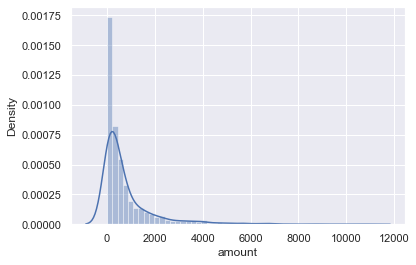

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
sns.distplot(df_train["amount"])

In [124]:
percentage_zero_target = round(
    len(df_train[df_train["amount"] == 0]) / len(df_train) * 100, 1
)
print(f"There is only {percentage_zero_target} % of targets equal to zero.")

There is only 5.4 % of targets equal to zero.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Plot errors

In [142]:
models_mae_errors

{'(0, 0, 0)': [421.36400704579785,
  255.0399166666667,
  1281.923611111111,
  196.86169117647066,
  430.2263371372539,
  279.5095572231552,
  543.5378602627707,
  233.3809490519169,
  1391.8160416666672,
  2228.3093287864467,
  263.95852706105535,
  146.6915697681456,
  275.85668650793656,
  155.74900793650795,
  179.53738095238094,
  175.53410407602672,
  1242.7657407731701,
  844.1809057971013,
  280.33479166666666,
  223.4930416666667,
  547.7414166666666,
  872.9042499455857,
  1083.788675722004,
  472.4274621212122,
  762.9180416666668,
  81.25174999819147,
  639.1613333333333,
  104.39075,
  639.687986061399,
  560.2369443035147,
  306.20000000000005],
 '(0, 0, 1)': [292.3786176600144,
  1489.4188663876203,
  218.1274056453693,
  488.2257049992146,
  331.4583964322701,
  423.09076069403056,
  271.99596122994154,
  3451.529037737758,
  258.6384356127932,
  159.30621411700773,
  240.0381938254762,
  171.88832522210714,
  212.00918972638993,
  184.5672266573873,
  987.0316240534557

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
FLOAT_FORMAT = "{:.2f}"


def compute_error_quantiles(
    errors: np.ndarray, quantiles: list, order: str
) -> pd.DataFrame:
    columns_names = [FLOAT_FORMAT.format(quantile) for quantile in quantiles]
    return pd.DataFrame(
        data=np.quantile(errors, quantiles, interpolation="linear"),
        index=columns_names,
        columns=[f"quantiles_{order}"],
    )


QUANTILES = [0.05 * i for i in range(1, 20)]

quantiles_errors = []
for order, mape_errors in models_mape_errors.items():
    quantiles_errors.append(
        compute_error_quantiles(
            errors=mape_errors, quantiles=QUANTILES, order=f"{order}"
        )
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [140]:
pd.concat(quantiles_errors, axis=1)

,"quantiles_(0, 0, 0)","quantiles_(0, 0, 1)","quantiles_(0, 1, 0)","quantiles_(0, 1, 1)","quantiles_(1, 0, 0)","quantiles_(1, 1, 0)"
0.05,61.699581,65.572677,78.463363,83.501942,64.132928,75.194330
0.10,67.203090,81.830276,101.636364,102.228931,79.076776,111.552293
0.15,83.826401,94.190203,116.461163,135.046285,98.263214,120.139352
0.20,139.007743,104.055009,128.450493,225.254444,159.779100,211.237136
0.25,194.763370,205.640190,218.279557,240.593030,201.595011,247.412243
0.30,225.583181,233.608559,227.358593,250.064052,213.870233,257.664685
0.35,240.030186,254.504943,259.315089,263.568388,252.913521,295.386054
0.40,261.790596,267.955146,333.724405,303.267651,264.342289,405.190804
0.45,314.465856,280.808961,398.839834,360.025311,329.131874,446.502394
0.50,366.030144,339.667940,452.714419,414.961090,380.164363,462.978606


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

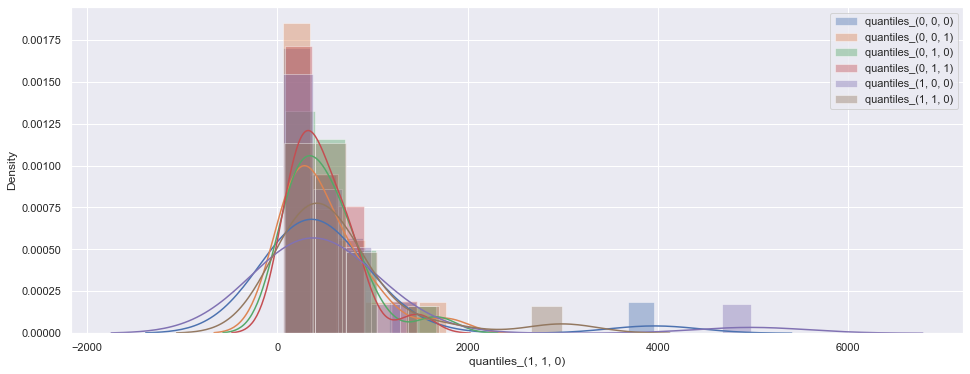

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [141]:
mape_errors_df_quantiles = pd.concat(quantiles_errors, axis=1)
plt.figure(figsize=(16, 6))
for column in mape_errors_df_quantiles.columns:
    sns.distplot(mape_errors_df_quantiles[column], label=column)

plt.legend()

Here we observe that the orange and red graphs are the most performing models when looking at the MAPE qauntiles. 
The orange curve have a lower median, but is more spread than the red one.


Let us look at the MAE

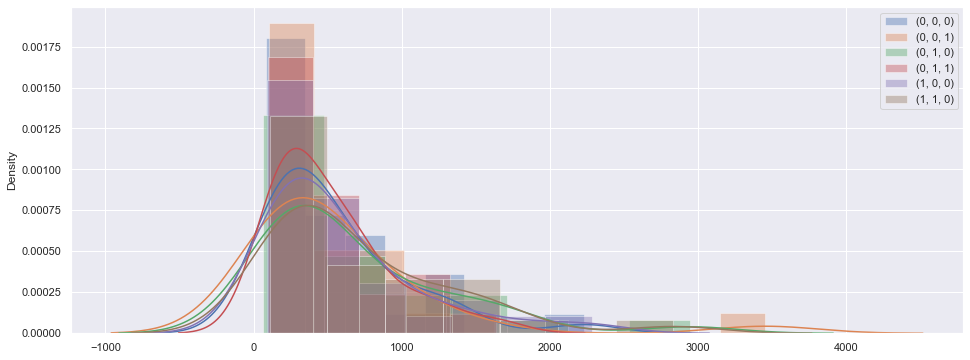

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [146]:
plt.figure(figsize=(16, 6))
for order, error in models_mae_errors.items():
    sns.distplot(error, label=order)

plt.legend()

The red curve seems to be the most performing one when looking at the distribution of MAE for each model.

Looking at the MAE is important too: the goal of the model could be to have the lowest error it total (and not by account). 

We can also look at the relative error, since a case might be better worse than the otehr. In my opinion underestimating the expenses is worse. The percentage of higher predictions might be an additional indicator of the performance of the models.

#### CONCLUSION : We keep ARIMA(0, 1, 1)

Let us apply the model on the test set.

In [147]:
test_mape_errors = {}
test_mae_errors = {}

for account_id in df_test["account_id"].unique():
    df_temp = df_test[df_test["account_id"] == account_id]
    try:
        mape_error, mae_error = evaluate_arima_model(df=df_temp, arima_order=(0, 1, 1))
        add_prediction_to_dict(
            predictions_dict=test_mape_errors, key=f"{(0, 1, 1)}", val=mape_error
        )
        add_prediction_to_dict(
            predictions_dict=test_mae_errors, key=f"{(0, 1, 1)}", val=mae_error
        )
    except:
        continue

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [151]:
test_mae_errors

{'(0, 1, 1)': [336.14098731792734,
  153.6175074125006,
  2382.9750233187497,
  153.7547557671951,
  371.37884551430466,
  237.44304590069527,
  420.38756094932035,
  190.81144651558938,
  451.0097457165651,
  334.6183839067951,
  171.52652786207162,
  391.58013624404686,
  117.56720338079766,
  298.13606416321124,
  200.64030535420918,
  301.4255232866706,
  126.53187941008416,
  507.89522450794084,
  1019.1259780844498,
  1125.454274940196,
  652.3693777033931,
  54.27263286573272,
  437.5738972300412,
  223.64221543972678,
  614.7569621602685,
  667.823851442396,
  304.2546955640534]}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [152]:
# MAE errors

compute_error_quantiles(
    errors=test_mae_errors['(0, 1, 1)'], quantiles=QUANTILES, order=f"{(0, 1, 1)}"
)


,"quantiles_(0, 1, 1)"
0.05,120.256606
0.10,142.783256
0.15,153.741031
0.20,175.383512
0.25,195.725876
0.30,219.041833
0.35,243.512348
0.40,299.451848
0.45,303.405944
0.50,334.618384


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [154]:
# MAPE errors

compute_error_quantiles(
    errors=[x for x in test_mae_errors['(0, 1, 1)'] if x == x], quantiles=QUANTILES, order=f"{(0, 1, 1)}"
)


,"quantiles_(0, 1, 1)"
0.05,120.256606
0.10,142.783256
0.15,153.741031
0.20,175.383512
0.25,195.725876
0.30,219.041833
0.35,243.512348
0.40,299.451848
0.45,303.405944
0.50,334.618384


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>